# Investigations

The relevant data structures will be saved in a dictionary and pickled for easy access.

## A. Pressure
### 1. Lateral resolution- 

Maximum Pressure
* Here we can take the maximum of pressure values over time.
* Disadvantage of this method is that it compresses the information in the time domain. Should only give information about the lateral resolution, not the axial resolution.
* We can also call this the 'tightness of focus.'

Root Mean Squared Pressure
* Similar analysis for lateral resolution

### 2. Beam profile-
Maximum pressure
* Use angular variation

### 3. Beam shearing- Wave shape cross correlation
This would allow us to assess where the ideal wave is most similar to the phase-wrapped one.

### 4. Degradation- Similarity over time 
We can use the Euclidean distance to assess similarity

## B. Intensity through a plane
We can also plot the intensity over time

### 1. Lateral resolution

### 1. Axial resolution- Intensity over time at the focus

### 2. Beam profile- Peak intensity at different depths

In [2]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

from scipy.signal import correlate
from operator import itemgetter


In [258]:
from preprocess import import_mat
path = '../raw_data/0309_'
# The length of array X depends on how many sensor variables are measured
X = import_mat(path + 'focus_30')


In [358]:
packet = {}

In [24]:
x = 100e-3
PML_X_SIZE = 20            # [grid points]
Nx = 256 - 2*PML_X_SIZE    # [grid points]

dx = x/ Nx
r = 25e-3/dx
print(r)

x_len, y_len, t_len = np.shape(X[0])

54.0


In [359]:
# Get average pressure over time, maximum and root mean squared
pressure_max = np.max(X[0], axis=2)
pressure_rms = np.sqrt(np.average(X[0]*X[0], axis=2))

packet['p_max'] = pressure_max
packet['p_rms'] = pressure_rms

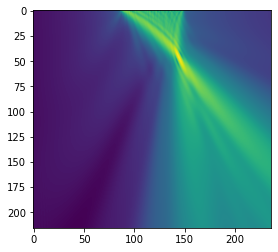

In [23]:
plt.imshow(pressure_rms)

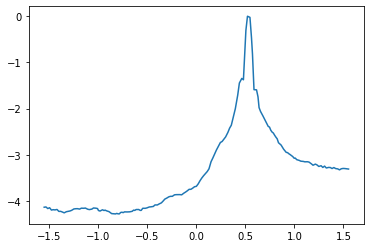

In [361]:
# Obtain beam profile based on the focus distance
values = []
for i in range(x_len):
    for j in range(y_len):
        centered = j- y_len/2 + 1
        radius = round(np.sqrt((centered)**2 + i**2))

        if (radius == r) and i > 0: 
            angle = np.arctan((centered) / i )
            values.append([angle, pressure_max[i,j]])

# Sort values based on the angles
values = sorted(values, key=itemgetter(0))

a, p = np.array(values).T
plt.plot(a,np.log(p/max(p)))
packet['beam_profile'] = np.array(values).T

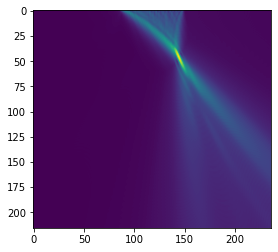

In [202]:
plt.imshow(pressure_max)

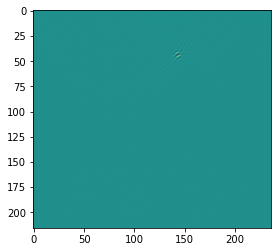

In [363]:
# Find time point with highest pressure, which should be the focus
t_foc = np.unravel_index(np.argmax(X[0]), X[0].shape)[2]
array = X[0, :,:,t_foc]
plt.imshow(array, vmin=-np.max(array), vmax= np.max(array))
packet['p_foc'] = array

In [320]:
t_foc = np.unravel_index(np.argmax(X[0]), X[0].shape)[2]
intensity = X[1:]
int_foc = X[1:,:,:,t_foc]

In [283]:
np.shape(int_foc)

(2, 216, 236)

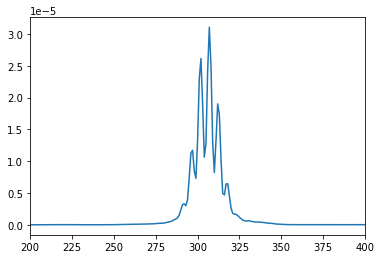

In [364]:
mask_list = []
for i in range(x_len):
    for j in range(y_len):
        centered = j- y_len/2 + 1
        radius = round(np.sqrt((centered)**2 + i**2))
        if (radius == r) and i > 0: 
            angle = np.arctan((centered) / i)
            mask_list.append([i,j,angle])

# Obtain intensity through a plane at a certain distance
intensities = []
for t in range(t_len): 
    temp = []
    for item in mask_list:
        i,j,angle = item[0],item[1],item[2]
        temp.append(intensity[0, i,j,t]*np.cos(angle) + intensity[1, i,j, t]*np.sin(angle))
    intensities.append(np.sum(temp))

plt.plot(intensities)
plt.xlim(200,400)
packet['intensity_time'] = intensities

In [350]:
intensities[0]

0.0

In [351]:
xs = np.arange(0, x_len)
ys = np.arange(-y_len/2 +1, y_len/2+1)
Xs, Ys = np.meshgrid(xs, ys)

mask = np.round(np.sqrt(Xs**2 + Ys**2)) == r 

In [352]:
intensity[:,mask.T,:]

array([[[ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         -4.47228328e-15, -3.58692826e-15,  4.06325156e-16],
        [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         -4.46296729e-15,  1.93935977e-14,  5.87170601e-15],
        [-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
          5.69588673e-15,  4.39964082e-15, -3.54999516e-16],
        ...,
        [-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
          5.97083209e-15,  1.26112716e-15, -4.02474419e-17],
        [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
          8.12847877e-15,  1.68363385e-16,  3.71121638e-15],
        [-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
         -1.29886222e-16,  3.68919279e-15,  2.64087527e-15]],

       [[-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
         -1.05057826e-13, -3.33731367e-14,  8.15130277e-16],
        [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
          2.52601897e-14,  2.48108012e